<p style="align: center;">
    <img align=center src="../img/dls_logo.jpg" width=500 height=500>
</p>

<h1 style="text-align: center;">
    Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ
</h1>

---

<h1 style="text-align: center;">
    Домашнее задание: градиентный спуск и линейные модели
</h1>

В этой домашке вы напишете свой класс логистической регрессии для многоклассовой классификации, а также логистическую регрессию с регуляризацией.

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

%matplotlib inline

In [2]:
np.random.seed(42)

## 1. Градиентный спуск: повторение

Рассмотрим функцию от двух переменных:

In [3]:
def f(x):
    """
    x: np.array(np.float) размерности 2
    return value: np.float
    """

    return np.sum(np.sin(x)**2, axis=0)

Обратите внимание, что $x$ - это `np.ndarray` размерности $2$.

**Напоминание:**

Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, **MSE**), а точнее найти $x_1$ и $x_2$ такие, что при них значение $f(x_1,x_2)$ минимально, то есть **точку экстремума**. 

Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - минимизации). Одним из таких методов и является **градиентный спуск**. 

Реализуем функцию, которая будет осуществлять градиентный спуск для функции $f$.

**Примечание:** вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) - в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(x): 
    """
    Градиент функциии f, определенной выше.
        x: np.array(np.float) размерности 2
        return value: np.array(np.float) размерности 2
    """

    return np.sin(2 * x)

In [5]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        f: скалярная функция двух переменных
        grad_f: градиент функции f (вектор размерности 2)
        lr: learning rate алгоритма
        num_iter: количество итераций градиентного спуска
        return value: np.array пар вида (x, f(x))
    """

    if x0 is None:
        x0 = np.random.random(2)
    
    # будем сохранять значения аргументов и значений функции 
    # в процессе градиентного спуска в переменную history
    history = []
    
    # итерация цикла - шаг градиентнго спуска
    curr_x = x0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)
        
        # обновите curr_x
        curr_x -= lr * grad_f(curr_x)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Кружочками будут обозначены точки (тройки $x_1, x_2, f(x_1, x_2)$), по которым ваш алгоритм градиентного спуска двигался к минимуму.

Для того, чтобы нарисовать этот график, мы и сохраняли значения $cur\_x_1, cur\_x_2, f(cur\_x_1, cur\_x_2)$ в `steps` в процессе спуска.

Если у вас правильно написана функция `grad_descent_2d`, то кружочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [6]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)

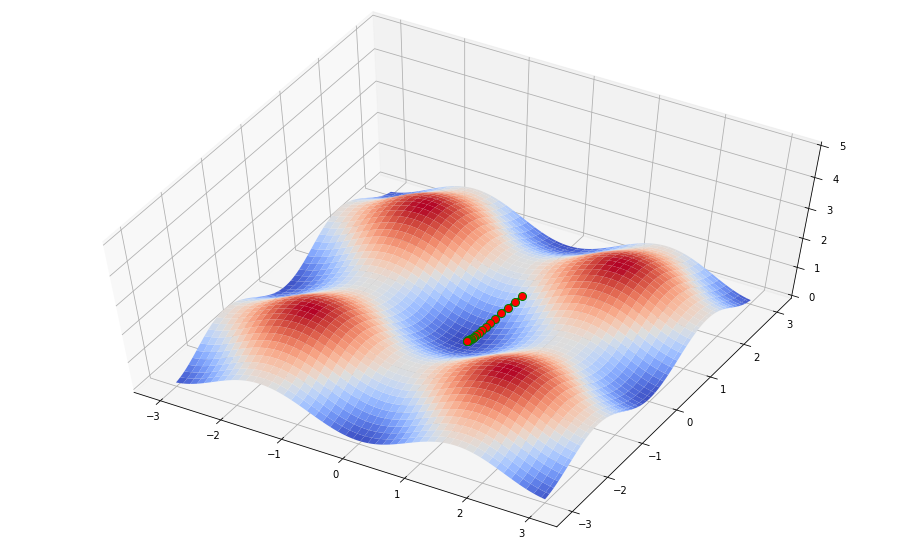

In [7]:
# %matplotlib osx

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

path = []

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, f([X, Y]), cmap=cm.coolwarm, zorder=2)

# редактируем настройки отображения траектории, сделанной градиентым спуском
ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
        marker='o', markersize=8, zorder=3, 
        markerfacecolor='red', lw=3, c='green')

ax.set_zlim(0, 5)
ax.view_init(elev=60)
plt.show()

Посмотрим на график зависимости значений функции от шага:

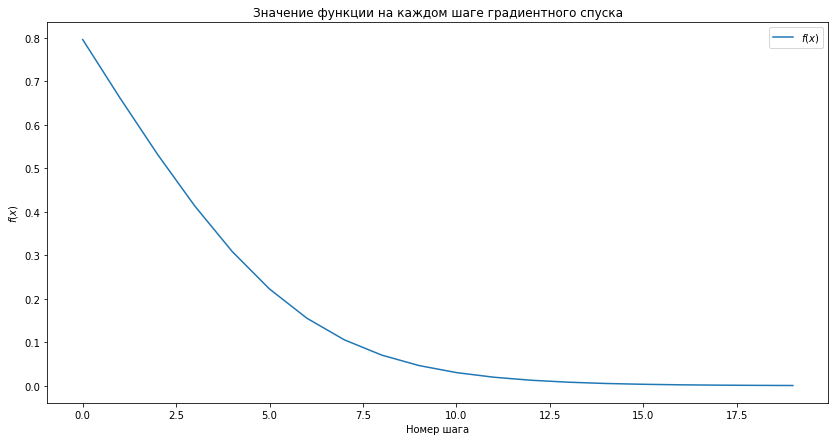

In [8]:
plt.figure(figsize=(14, 7))
plt.xlabel('Номер шага')
plt.ylabel('$f(x)$')
plt.title('Значение функции на каждом шаге градиентного спуска')

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label='$f(x)$')
plt.legend()
plt.show()

Когда вы используете градиентный спуск, всегда нужно проверять, сошёлся ли он. К сожалению, для большинства моделей не получится построить 3D-график, поэтому обязательно нужно смотреть на то, как менялся лосс на каждом шаге градиентного спуска.

## 2. Генератор батчей

Обычно генерация батчей отличается от той, которую мы использовали в семинаре. Мы выбирали `batch_size` случайных строчек на каждом шаге, но у такого подхода есть минусы. Основной заключается в том, что некоторые строчки из обучающего датасета могут попадаться значительно реже, чем другие.

Чтобы это исправить, обучение делят на эпохи. Мы хотим, чтобы в течение одной эпохи модель обучилась на каждом примере один раз. Для этого нужно перемешать строчки в датасете и каждый раз брать очередные `batch_size` строчек. 

Может так получиться, что размер датасета не делится на `batch_size`, тогда последний батч будет состоять из нескольких последних строк и его размер будет меньше, чем `batch_size`. Такой батч иногда выкидывают и просто не используют. Именно так вам нужно поступить в этом задании.

Напишите генератор батчей, который будет принимать на вход признаки, ответы и размер батча. Генератор должен возвращать `tuple` из `X_batch, y_batch`. Если размер датасета не делится на `batch_size`, то последний маленький батч возвращать не нужно. 

Подробнее про генераторы в `Python` можно прочитать здесь:

* [Документация](https://wiki.python.org/moin/Generators)

* [Описание на русском](https://pythoner.name/list-generator)

Чтобы не перемешивать сам датасет, воспользуйтесь `np.random.permutation`.

In [9]:
def generate_batches(X, y, batch_size):
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    num_batches = len(X) // batch_size
    for i in range(num_batches):
        ind = perm[i * batch_size : (i + 1) * batch_size]
        yield X[ind], y[ind]

Проверим, что наш генератор батчей перемешивает датасет и каждый элемент встречается один раз:

In [10]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all()
assert (y_fake != y_reconstructed).all()

assert (np.sort(X_reconstructed) == X_fake).all

Попробуем теперь такой `batch_size`, что размера датасета не делится на него нацело:

In [11]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7

## 3. Логистическая регрессия с $l_1$ и $l_2$ регуляризацией (elastic net)

Ваша задача - написать класс логистической регрессии с обеими регуляризациями и оптимизацией с помощью **SGD**, используя генератор батчей, который вы написали выше.

In [20]:
def logit(x, w):
    return np.dot(x, w)


def sigmoid(x):
    return 1. / (1 + np.exp(-x))


class MyElasticLogisticRegression:
    
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None
    
    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        n, k = X.shape
        
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        # положите в массив losses лосс на каждом батче
        # не нужно усреднять лосс по эпохе
        losses = []
        
        for X_batch, y_batch in generate_batches(X_train, y, batch_size):
            self.w -= lr * self.get_grad(X_batch, y_batch, )
            losses.append(self.__loss(X_batch, self.predict_proba(X_bacth)))
        
        return losses
    
    def get_grad(self, X_batch, y_batch, predictions):
        """
        Принимает на вход X_batch с уже добавленной колонкой единиц. 
        НЕ НУЖНО РЕГУЛЯРИЗИРОВАТЬ BIAS.
        """
        
        z = sigmoid(logit(X_batch, self.w))
        grad = (z - y_batch).dot(X_batch) / len(y_batch) 
        
        return grad
        
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w
      
    def __loss(self, y, p):  
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

Протестируем на искусственных данных:


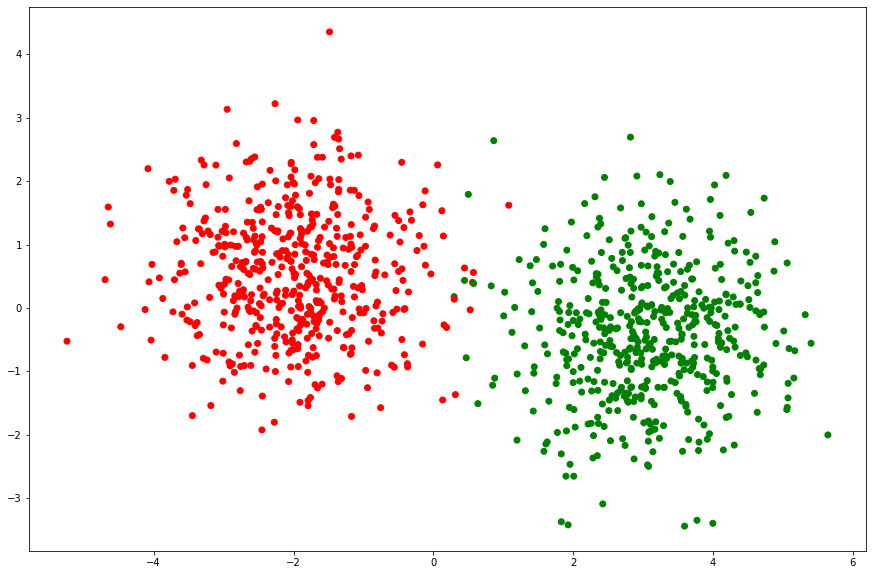

In [21]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [22]:
clf = MyElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

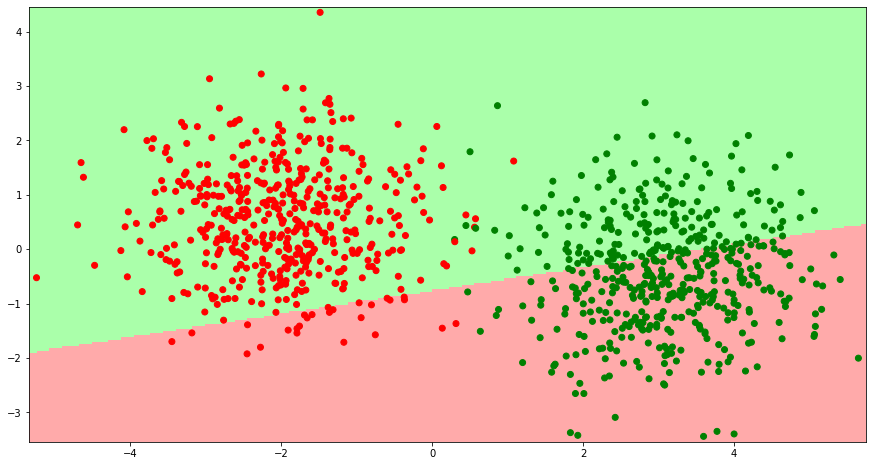

In [23]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

Теперь протестируем на датасете **MNIST**. Это очень простой класический датасет, на котором часто тестируются модели. С помощью нейронных сетей люди научились получать на нём качество $99.84\%$. 

Датасет состоит из черно-белых картинок с цифрами. ![mnist-3.0.1.png](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Так как мы сделали классификатор для двух классов, то мы выберем из всех картинок только картинки $0$ и $1$, пр превратим их из двумерной матрицы в вектор и обучим нашу модель.

In [18]:
data = pd.read_csv('data/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Данные выглядят как таблица, первая колонка которой - это `label`, т.е. цифра, которая изображена на картинке, а следующие $784$ колонки - это значения от $0$ до $255$, описывающие все пиксели картинки $28 \times 28$. То есть нам не придётся использовать `reshape` и превращать матрицу в вектор, так как это уже сделано.

In [19]:
X = data.iloc[:, 1:]
y = data.iloc[:, 1]

# выберем только картинки, где изображён 0 и 1
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

Для оценки модели воспользуемся кросс-валидацией:

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# YOUR CODE
# Сделайте sklearn pipeline с StandarScaler и MyElasticLogisticRegression и проверьте точность с помощью cross_val_score.
# в качестве scorer используйте 'accuracy'. Эта часть не проверяется в степике.

print(f'Mean accuracy of Logistic Regression for two classes is {mean_accuracy}')